## Libraries and Helper Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load

import re
import string
import nltk
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD

from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired,MaximalMarginalRelevance
from bertopic.representation import OpenAI as OpenAI_BERTopic
from sentence_transformers import SentenceTransformer

from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

import os
from dotenv import load_dotenv

import optuna

nltk.download('punkt')
nltk.download('stopwords')

import torch
import random
import os

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hanif\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hanif\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
load_dotenv(override=True)

True

In [3]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.StopWordRemover.StopWordRemover import StopWordRemover

In [4]:
import openai
from openai import OpenAI
import json

openai.api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI()

def summarize_topic(keywords, docs):
    prompt = f"Saya mempunyai sebuah topik terkait literatur ilmiah terkait riset dan inovasi kecerdasan buatan yang dapat di-deskripsikan dengan beberapa kata kunci berikut: {keywords}\n\n"
    prompt += "Di dialam topik ini, dokumen-dokumen berikut yang merupakan abstrak dari literatur ilmiah merupakan sebagian kecil namun representatif dari semua dokumen dalam topik ini:\n\n"
    prompt += "\n\n".join(docs[:5])  # ambil 5 dokumen saja
    prompt += 'Berdasarkan informasi di atas, deskripsikan topik ini dan berikan label berupa satu kaliamat yang representatif terhadap topik ini dengan format JSON berikut:\n {"label_topik":<label> , "deskripsi":<deskripsi>}'
    response = client.chat.completions.create(
        model="gpt-4o-2024-08-06",
        messages=[
            {"role": "system", "content": 'Kamu adalah asisten akademik yang merangkum topik. Anda adalah model yang hanya menjawab dalam format JSON valid. Jangan beri penjelasan. Berikan hanya output seperti ini: {"label_topik": "...", "deskripsi": "..."}'},
            {"role": "user", "content": prompt}
        ],
        temperature=0.5,
        max_tokens=300
    )
    content = response.choices[0].message.content.strip()
    try:
        match = re.search(r'\{.*?\}', content, re.DOTALL)
        json_str = match.group(0)
        result = json.loads(json_str)
        return result
    except json.JSONDecodeError:
        print("JSON tidak valid")

In [5]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hanif\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hanif\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
import time
class StopWatch():
    def __init__(self):
        self.__start_time = 0
        self.__end_time = 0
        self.__elapsed_time = 0
    def start(self):
        self.__start_time = time.time()
        self.__end_time = 0
    def stop(self):
        self.__end_time = time.time()
        self.__elapsed_time = self.__end_time - self.__start_time
    def print(self):
        detik = self.__elapsed_time

        jam = detik // 3600
        detik = detik % 3600

        menit = detik // 60
        detik = detik % 60

        print('Waktu eksekusi: ',end='')
        if jam != 0:
            print(int(jam),'jam ',end='')
        if menit != 0:
            print(int(menit),'menit',end='')
        print(f' {detik:.2f}','detik.')
    def get_elapsed_time(self):
        return self.__elapsed_time

In [7]:
factory = StopWordRemoverFactory()
stopword_remover = factory.create_stop_word_remover()  
repeated_phrases = ["kecerdasan buatan"]

additional_stop_words = ['ai']

stop_words = set(stopwords.words('english'))
for word in additional_stop_words:
    stop_words.add(word)

def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    
    # URL removal
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Punctuation removal
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove repeated phrases
    for phrase in repeated_phrases:
        text = re.sub(phrase,"",text)

    # Remove duplicate white space
    text = re.sub(r'\s+', ' ', text)
    
    text = stopword_remover.remove(text) 

     # Tokenization
    tokens = word_tokenize(text)
    
    # Stopword removal
    tokens = [word for word in tokens if word not in stop_words]
    
    return ' '.join(tokens)

In [8]:
def trim(x):
    if x[-8:]=='Collapse':
        return x[:-8]
    elif x[-9:] == ' … Expand':
        return x[:-9]
    else:
        return x

In [9]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic #{topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [10]:
def get_topics_words(model, vectorizer):
    feature_names = vectorizer.get_feature_names_out()
    topics_words = []
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-11:-1]
        top_words = [feature_names[i] for i in top_features_ind]
        topics_words.append(top_words)

    return topics_words

def get_bert_topics_words(topic_model):
    bert_topics_words = []
    for topic_id in topic_model.get_topics().keys():
        if topic_id == -1:
            continue
        topic_words = [word for word, _ in topic_model.get_topic(topic_id)]
        bert_topics_words.append(topic_words)
    return bert_topics_words

def get_coherence(topics_words):
    sw = StopWatch()
    sw.start()
    
    coherence = CoherenceModel(
                    topics=topics_words,
                    texts=tokenized_docs,
                    dictionary=dictionary,
                    coherence='c_v'
                ).get_coherence()

    sw.stop()
    sw.print()

    return coherence

In [11]:
config = {
    'dataset_dir' : '../../Datasets/'
}

## EDA

In [12]:
df = pd.read_csv(config['dataset_dir']+'artikel.csv')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 877 entries, 0 to 876
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     877 non-null    object
 1   abstract  877 non-null    object
 2   pubdate   877 non-null    object
dtypes: object(3)
memory usage: 20.7+ KB


In [14]:
df.head()

,title,abstract,pubdate
0,Pemanfaatan Kecerdasan Buatan dalam Analisis R...,Purpose – Paper ini bertujuan untuk mengevalua...,31 October 2024
1,Simulasi Perilaku Kecerdasan Buatan dengan Per...,Permainan Multiplayer Online Battle Arena (MOB...,15 July 2024
2,Ketika Kecerdasan Buatan Menjadi Alat Kecurang...,This study aims to explore the influence of pe...,31 October 2024
3,ANALISIS KECERDASAN BUATAN CHATGPT DALAM PENYE...,Penggunaan teknologi merupakan hal yang tidak ...,31 July 2023
4,Pemanfaatan Kecerdasan Buatan (Ai) Dalam Menin...,"Usaha Mikro, Kecil, dan Menengah (UMKM) play a...",22 December 2023


In [15]:
df['pub_year'] = df['pubdate'].apply(lambda x: x[-4:]).astype(int)
df.drop(columns=['pubdate'],inplace=True)

## Preprocessing and Feature Engineering #1

In [16]:
df_tm = df.copy()
df_tm['text'] = df_tm['title']+" "+df_tm['abstract']
df_tm['text'] = df_tm['text'].apply(trim)

df_tm = df_tm[['text']]

In [17]:
sw = StopWatch()
sw.start()
df_tm['processed_text'] = df_tm['text'].apply(preprocess_text)
sw.stop()
sw.print()

Waktu eksekusi:  0.97 detik.


In [18]:
df_tm.head()

,text,processed_text
0,Pemanfaatan Kecerdasan Buatan dalam Analisis R...,pemanfaatan analisis return risiko saham lq45 ...
1,Simulasi Perilaku Kecerdasan Buatan dengan Per...,simulasi perilaku peran support enchanter meng...
2,Ketika Kecerdasan Buatan Menjadi Alat Kecurang...,menjadi alat kecurangan tingkat lanjut tantang...
3,ANALISIS KECERDASAN BUATAN CHATGPT DALAM PENYE...,analisis chatgpt penyelesaian soal fisika berg...
4,Pemanfaatan Kecerdasan Buatan (Ai) Dalam Menin...,pemanfaatan meningkatkan efesiensi pengembanga...


## Topic Modelling

In [19]:
docs = df_tm['processed_text'].to_list()

In [20]:
def get_top_keyword(vectorizer,model):
    componenets = model.components_
    feature_names = vectorizer.get_feature_names_out()
    top_n = 10
    keywords_per_topic = [
        [feature_names[i] for i in topic.argsort()[:-top_n - 1:-1]] for topic in componenets
    ]
    return keywords_per_topic

def select_representative_docs(model,topics):
    topics_docs = {}
    for topic_idx in range(model.n_components):
        topic_strength = topics[:,topic_idx]
        top_doc_indices = topic_strength.argsort()[::-1][:5]
        topics_docs[topic_idx] = [docs[i] for i in top_doc_indices]
    return topics_docs

In [21]:
def summarize(model, topics, vectorizer):
    r_docs = select_representative_docs(model,topics)
    top_key = get_top_keyword(vectorizer,model)
    topic_desc = {}
    for topic_idx, keywords in enumerate(top_key):
        docs_sample = r_docs[topic_idx]
        result = summarize_topic(keywords, docs_sample)
        topic_desc[topic_idx] = result
    return topic_desc

In [22]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf = tfidf_vectorizer.fit_transform(df_tm['processed_text'])

count_vectorizer = CountVectorizer(max_features=1000)
count = count_vectorizer.fit_transform(df_tm['processed_text'])

### NMF

In [23]:
sw = StopWatch()
sw.start()
nmf_model = NMF(n_components=10, random_state=42)
nmf_topics = nmf_model.fit_transform(tfidf)
sw.stop()
sw.print()

Waktu eksekusi:  0.13 detik.


In [24]:
df_tm['NMF_topic'] = np.argmax(nmf_topics,axis=1)

In [25]:
df_tm['NMF_topic'].value_counts()

NMF_topic
2    236
1    130
8     90
4     82
6     81
9     69
0     59
5     59
3     37
7     34
Name: count, dtype: int64

### LDA

In [26]:
sw = StopWatch()
sw.start()
lda_model = LatentDirichletAllocation(n_components=10, random_state=42)
lda_topics = lda_model.fit_transform(count)
sw.stop()
sw.print()

Waktu eksekusi:  4.14 detik.


In [27]:
df_tm['LDA_topic'] = np.argmax(lda_topics,axis=1)

In [28]:
df_tm['LDA_topic'].value_counts()

LDA_topic
6    211
2    125
3    112
0     94
5     87
4     74
1     54
8     45
7     42
9     33
Name: count, dtype: int64

### LSA

In [29]:
sw = StopWatch()
sw.start()
lsa_model = TruncatedSVD(n_components=10, random_state=42)
lsa_topics = lsa_model.fit_transform(tfidf)
sw.stop()
sw.print()

Waktu eksekusi:  0.04 detik.


In [30]:
df_tm['LSA_topics'] = np.argmax(lsa_topics,axis=1)

In [31]:
df_tm['LSA_topics'].value_counts()

LSA_topics
0    738
5     36
3     31
7     26
4     17
6     16
9      8
2      3
8      2
Name: count, dtype: int64

### BERTopic

In [32]:
# Prepare sub-models
embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
umap_model = UMAP(n_components=5, n_neighbors=50, random_state=42, metric="cosine", verbose=True)
hdbscan_model = HDBSCAN(min_samples=20, gen_min_span_tree=True, prediction_data=True, min_cluster_size=20)
vectorizer_model = CountVectorizer(ngram_range=(1, 3), min_df=5)

In [33]:
# Representation models
representation_models = {
    "KeyBERTInspired": KeyBERTInspired(),
    "MMR": MaximalMarginalRelevance(diversity=0.3),
    "KeyBERT + MMR": [KeyBERTInspired(), MaximalMarginalRelevance(diversity=0.3)]
}

# Fit BERTopic
sw = StopWatch()
sw.start()

topic_model= BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        representation_model=representation_models,
        verbose=True
).fit(docs)

sw.stop()
sw.print()

2025-07-26 16:19:56,460 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/28 [00:00<?, ?it/s]

2025-07-26 16:19:59,195 - BERTopic - Embedding - Completed ✓
2025-07-26 16:19:59,197 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


UMAP(angular_rp_forest=True, metric='cosine', n_components=5, n_jobs=1, n_neighbors=50, random_state=42, verbose=True)
Sat Jul 26 16:19:59 2025 Construct fuzzy simplicial set
Sat Jul 26 16:20:00 2025 Finding Nearest Neighbors
Sat Jul 26 16:20:12 2025 Finished Nearest Neighbor Search
Sat Jul 26 16:20:16 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs


2025-07-26 16:20:20,012 - BERTopic - Dimensionality - Completed ✓
2025-07-26 16:20:20,013 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-26 16:20:20,042 - BERTopic - Cluster - Completed ✓
2025-07-26 16:20:20,045 - BERTopic - Representation - Fine-tuning topics using representation models.


	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sat Jul 26 16:20:20 2025 Finished embedding


2025-07-26 16:20:22,663 - BERTopic - Representation - Completed ✓


Waktu eksekusi:  26.49 detik.


In [34]:
topic_info = topic_model.get_topic_info()  
id_to_name = topic_info.set_index("Topic")["Name"].to_dict()

In [35]:
id_to_name

{-1: '-1_penelitian_teknologi_data_menggunakan',
 0: '0_pembelajaran_pendidikan_siswa_penelitian',
 1: '1_teknologi_digital_indonesia_penelitian',
 2: '2_chatgpt_chatbot_informasi_penelitian',
 3: '3_pakar_sistem_metode_kesehatan',
 4: '4_pendidikan_pembelajaran_penelitian_bahasa',
 5: '5_model_citra_klasifikasi_menggunakan',
 6: '6_algoritma_karakter_machine_satu'}

In [36]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERTInspired,MMR,KeyBERT + MMR,Representative_Docs
0,-1,368,-1_penelitian_teknologi_data_menggunakan,"[penelitian, teknologi, data, menggunakan, has...","[artificial intelligence, penelitian bertujuan...","[teknologi, data, artificial, pendidikan, inte...","[artificial intelligence, penelitian bertujuan...",[transformasi digital pendidikan tantangan pel...
1,0,146,0_pembelajaran_pendidikan_siswa_penelitian,"[pembelajaran, pendidikan, siswa, penelitian, ...","[pembelajaran berbasis, artificial intelligenc...","[pembelajaran, pendidikan, teknologi, artifici...","[pembelajaran berbasis, artificial intelligenc...",[pendidikan meningkatkan pembelajaran personal...
2,1,121,1_teknologi_digital_indonesia_penelitian,"[teknologi, digital, indonesia, penelitian, da...","[perkembangan teknologi, inovasi, era digital,...","[teknologi, digital, indonesia, data, bisnis, ...","[perkembangan teknologi, inovasi, era digital,...",[mengungkap dampaknya peran teknologi revolusi...
3,2,74,2_chatgpt_chatbot_informasi_penelitian,"[chatgpt, chatbot, informasi, penelitian, maha...","[chatgpt, chatbot, penelitian bertujuan, perke...","[chatgpt, chatbot, informasi, aplikasi, menggu...","[chatgpt, chatbot, penelitian bertujuan, perke...",[identifikasi pengaruh penggunaan chatgpt kema...
4,3,53,3_pakar_sistem_metode_kesehatan,"[pakar, sistem, metode, kesehatan, menggunakan...","[ilmu komputer, machine learning, menggunakan ...","[sistem, kesehatan, data, menggunakan metode, ...","[ilmu komputer, machine learning, menggunakan ...",[sistem pakar diagnosa penyakit kepiting bakau...
5,4,43,4_pendidikan_pembelajaran_penelitian_bahasa,"[pendidikan, pembelajaran, penelitian, bahasa,...","[media pembelajaran, pendidikan, education, pe...","[pendidikan, pembelajaran, penelitian, teknolo...","[media pembelajaran, pendidikan, education, pe...",[dampak penggunaan artificial intelligence pem...
6,5,39,5_model_citra_klasifikasi_menggunakan,"[model, citra, klasifikasi, menggunakan, machi...","[artificial intelligence, machine learning, al...","[model, klasifikasi, machine, learning, data, ...","[artificial intelligence, machine learning, al...",[hitung cepat buah jeruk berbeda kultivar poho...
7,6,33,6_algoritma_karakter_machine_satu,"[algoritma, karakter, machine, satu, perilaku,...","[algoritma digunakan, aplikasi, menggunakan al...","[algoritma, machine, perilaku, menggunakan, ch...","[algoritma digunakan, aplikasi, menggunakan al...",[penerapan pathfinding fsm finite state machin...


In [37]:
sw = StopWatch()
sw.start()

bert_topics, probs = topic_model.transform(docs)

sw.stop()
sw.print()

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

2025-07-26 16:20:25,448 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-07-26 16:20:25,451 - BERTopic - Dimensionality - Completed ✓
2025-07-26 16:20:25,451 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-07-26 16:20:25,485 - BERTopic - Cluster - Completed ✓


Waktu eksekusi:  2.46 detik.


In [38]:
df_tm['BERT_topic'] = bert_topics

### Evaluating #1

In [23]:
# Tokenisasi dokumen
tokenized_docs = [doc.split() for doc in docs]

dictionary = Dictionary(tokenized_docs)
corpus = [dictionary.doc2bow(text) for text in tokenized_docs]

In [40]:
nmf_topics_words = get_topics_words(nmf_model,tfidf_vectorizer)
lda_topics_words = get_topics_words(lda_model,count_vectorizer)
lsa_topics_words = get_topics_words(lsa_model,tfidf_vectorizer)

In [41]:
bert_topics_words = get_bert_topics_words(topic_model)

In [42]:
sw.start()

coherence_dict = {
    'Model' : [
        'NMF',
        'LDA',
        'LSA',
        'BERTopic',
    ],
    'Coherence':[
        get_coherence(nmf_topics_words),
        get_coherence(lda_topics_words),
        get_coherence(lsa_topics_words),
        get_coherence(bert_topics_words),
    ]
}

sw.stop()
sw.print()

Waktu eksekusi:  10.52 detik.
Waktu eksekusi:  10.42 detik.
Waktu eksekusi:  10.29 detik.
Waktu eksekusi:  11.06 detik.
Waktu eksekusi:  42.29 detik.


In [43]:
coherence_df = pd.DataFrame(coherence_dict)

In [44]:
coherence_df

,Model,Coherence
0,NMF,0.680371
1,LDA,0.560703
2,LSA,0.531730
3,BERTopic,0.501530


### Hyperparameter Tuning

In [45]:
optuna.__version__

'4.4.0'

In [24]:
def nmf_objective(trial):
    params = {
        'n_components': trial.suggest_int('n_components', 3, 30)
    }

    model = NMF(**params, random_state=42)
    topics = model.fit_transform(tfidf)

    topics_words = get_topics_words(model, tfidf_vectorizer)
    return get_coherence(topics_words)

def lda_objective(trial):
    params = {
        'n_components': trial.suggest_int('n_components', 3, 30)
    }

    model = LatentDirichletAllocation(**params, random_state=42)
    topics = model.fit_transform(count)

    topics_words = get_topics_words(model, count_vectorizer)
    return get_coherence(topics_words)

def lsa_objective(trial):
    params = {
        'n_components': trial.suggest_int('n_components', 3, 30)
    }

    model = TruncatedSVD(**params, random_state=42)
    topics = model.fit_transform(tfidf)

    topics_words = get_topics_words(model, tfidf_vectorizer)
    return get_coherence(topics_words)

def bert_objective(trial):
    embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
    umap_model = UMAP(n_components=5, n_neighbors=50, random_state=42, metric="cosine", verbose=True)
    hdbscan_model = HDBSCAN(min_samples=20, gen_min_span_tree=True, prediction_data=True, min_cluster_size=trial.suggest_int('min_cluster_size', 3, 30))
    vectorizer_model = CountVectorizer(ngram_range=(1, 3), min_df=5)

    representation_models = {
        "KeyBERTInspired": KeyBERTInspired()
    }

    topic_model= BERTopic(
            embedding_model=embedding_model,
            umap_model=umap_model,
            hdbscan_model=hdbscan_model,
            vectorizer_model=vectorizer_model,
            representation_model=representation_models,
            verbose=True
    ).fit(docs)

    bert_topics_words = get_bert_topics_words(topic_model)
    return get_coherence(bert_topics_words)

In [25]:
# sw.start()

# nmf_study = optuna.create_study(direction='maximize')
# nmf_study.optimize(nmf_objective,n_trials=20)

# sw.stop()
# sw.print()

In [26]:
nmf_parmas = {'n_components': 12}

In [27]:
# sw.start()

# lda_study = optuna.create_study(direction='maximize')
# lda_study.optimize(lda_objective,n_trials=20)

# sw.stop()
# sw.print()

In [28]:
lda_params = {'n_components': 16}

In [29]:
# sw.start()

# lsa_study = optuna.create_study(direction='maximize')
# lsa_study.optimize(lsa_objective,n_trials=20)

# sw.stop()
# sw.print()

In [30]:
lsa_params = {'n_components': 4}

In [31]:
# sw.start()

# bert_study = optuna.create_study(direction='maximize')
# bert_study.optimize(bert_objective,n_trials=5)

# sw.stop()
# sw.print()

In [32]:
bert_params = {'min_cluster_size': 22}

In [33]:
nmf_model = NMF(**nmf_parmas, random_state=42)
nmf_topics = nmf_model.fit_transform(tfidf)

lda_model = LatentDirichletAllocation(**lda_params, random_state=42)
lda_topics = lda_model.fit_transform(count)

lsa_model = TruncatedSVD(**lsa_params, random_state=42)
lsa_topics = lsa_model.fit_transform(tfidf)

In [34]:
# Prepare sub-models
embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
umap_model = UMAP(n_components=5, n_neighbors=50, random_state=42, metric="cosine", verbose=True)
hdbscan_model = HDBSCAN(min_samples=20, gen_min_span_tree=True, prediction_data=True, min_cluster_size=22)
vectorizer_model = CountVectorizer(ngram_range=(1, 3), min_df=5)

# Representation models
representation_models = {
    "KeyBERTInspired": KeyBERTInspired(),
    "MMR": MaximalMarginalRelevance(diversity=0.3),
    "KeyBERT + MMR": [KeyBERTInspired(), MaximalMarginalRelevance(diversity=0.3)]
}

# Fit BERTopic
sw = StopWatch()
sw.start()

topic_model= BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        representation_model=representation_models,
        verbose=True
).fit(docs)

sw.stop()
sw.print()

2025-07-28 20:52:24,809 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/28 [00:00<?, ?it/s]

2025-07-28 20:52:27,494 - BERTopic - Embedding - Completed ✓
2025-07-28 20:52:27,495 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


UMAP(angular_rp_forest=True, metric='cosine', n_components=5, n_jobs=1, n_neighbors=50, random_state=42, verbose=True)
Mon Jul 28 20:52:27 2025 Construct fuzzy simplicial set
Mon Jul 28 20:52:28 2025 Finding Nearest Neighbors
Mon Jul 28 20:52:39 2025 Finished Nearest Neighbor Search
Mon Jul 28 20:52:43 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs


2025-07-28 20:52:46,955 - BERTopic - Dimensionality - Completed ✓
2025-07-28 20:52:46,957 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-28 20:52:46,987 - BERTopic - Cluster - Completed ✓
2025-07-28 20:52:46,990 - BERTopic - Representation - Fine-tuning topics using representation models.


	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Jul 28 20:52:46 2025 Finished embedding


2025-07-28 20:52:49,990 - BERTopic - Representation - Completed ✓


Waktu eksekusi:  25.45 detik.


In [35]:
nmf_topics_words = get_topics_words(nmf_model,tfidf_vectorizer)
lda_topics_words = get_topics_words(lda_model,count_vectorizer)
lsa_topics_words = get_topics_words(lsa_model,tfidf_vectorizer)

In [36]:
bert_topics_words = get_bert_topics_words(topic_model)

In [37]:
sw.start()

coherence_dict = {
    'Model' : [
        'NMF',
        'LDA',
        'LSA',
        'BERTopic',
    ],
    'Coherence':[
        get_coherence(nmf_topics_words),
        get_coherence(lda_topics_words),
        get_coherence(lsa_topics_words),
        get_coherence(bert_topics_words),
    ]
}

sw.stop()
sw.print()

Waktu eksekusi:  10.79 detik.
Waktu eksekusi:  10.56 detik.
Waktu eksekusi:  10.04 detik.
Waktu eksekusi:  9.98 detik.
Waktu eksekusi:  41.38 detik.


In [40]:
coherence_df = pd.DataFrame(coherence_dict)
coherence_df.sort_values(by='Coherence',ascending=False)

,Model,Coherence
0,NMF,0.694136
2,LSA,0.613363
1,LDA,0.561471
3,BERTopic,0.501530


## Conclusion

In [69]:
df['NMF_Topic'] = np.argmax(nmf_model.transform(tfidf),axis=1)

In [73]:
df['processed_text'] = df_tm['processed_text']

In [75]:
with open("nmf_sum.json", "r", encoding="utf-8") as f:
    nmf_sum = json.load(f)

In [82]:
nmf_sum['0']

{'label_topik': 'Integrasi AI dalam Pendidikan Agama Islam',
 'deskripsi': 'Topik ini membahas dampak dan tantangan integrasi kecerdasan buatan dalam pendidikan agama Islam, termasuk peningkatan efisiensi pembelajaran, personalisasi materi, dan pengembangan kompetensi keagamaan, serta tantangan terkait privasi, keamanan data, dan kesiapan infrastruktur.'}

In [88]:
df['label_topik'] = df['NMF_Topic'].apply(lambda x: nmf_sum[str(x)]['label_topik'])

In [104]:
def plot_topik_by_tahun(df, tahun):
    """
    Membuat barplot distribusi label_topik untuk tahun tertentu.

    Parameter:
    - df: DataFrame yang berisi kolom 'label_topik' dan 'pubdate'
    - tahun: Tahun (integer) yang ingin divisualisasikan
    """
    # Filter berdasarkan tahun
    df_filtered = df[df['pub_year'] == tahun]

    if df_filtered.empty:
        print(f"Tidak ada data untuk tahun {tahun}")
        return

    # Hitung frekuensi topik
    topic_counts = df_filtered['label_topik'].value_counts()

    # Plot barplot
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x=topic_counts.values,
        y=topic_counts.index,
        palette="viridis"
    )
    plt.xlabel("Jumlah")
    plt.ylabel("Topik")
    plt.title(f"Distribusi Topik Literatur Ilmiah Berbahasa Indonesia pada Tahun {tahun}")

    # Ambil 5 topik teratas untuk legend
    top_5_labels = topic_counts.head(5).index.tolist()

    # # Tambahkan legend manual
    # from matplotlib.patches import Patch
    # legend_handles = [Patch(color=sns.color_palette("viridis")[i], label=label)
    #                   for i, label in enumerate(top_5_labels)]
    # plt.legend(handles=legend_handles, title="5 Topik Teratas", loc="upper right")

    plt.tight_layout()
    plt.savefig(f"Distribusi Topik Literatur Ilmiah Berbahasa Indonesia pada Tahun {tahun}.png",dpi=300, bbox_inches="tight")
    plt.show()

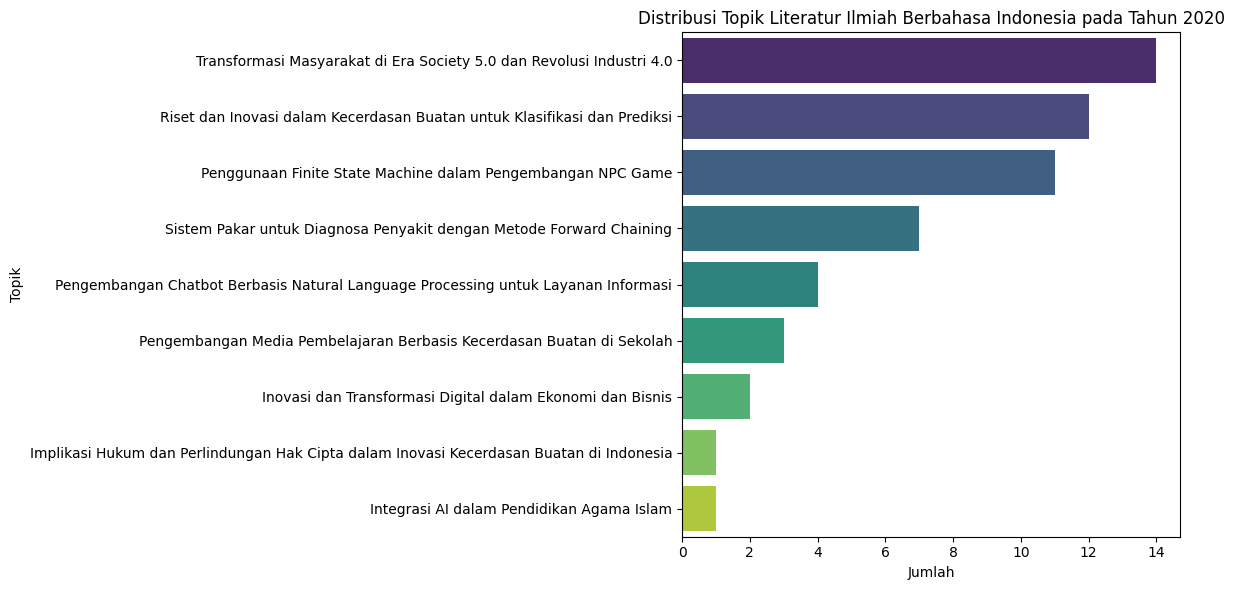

In [105]:
plot_topik_by_tahun(df,2020)

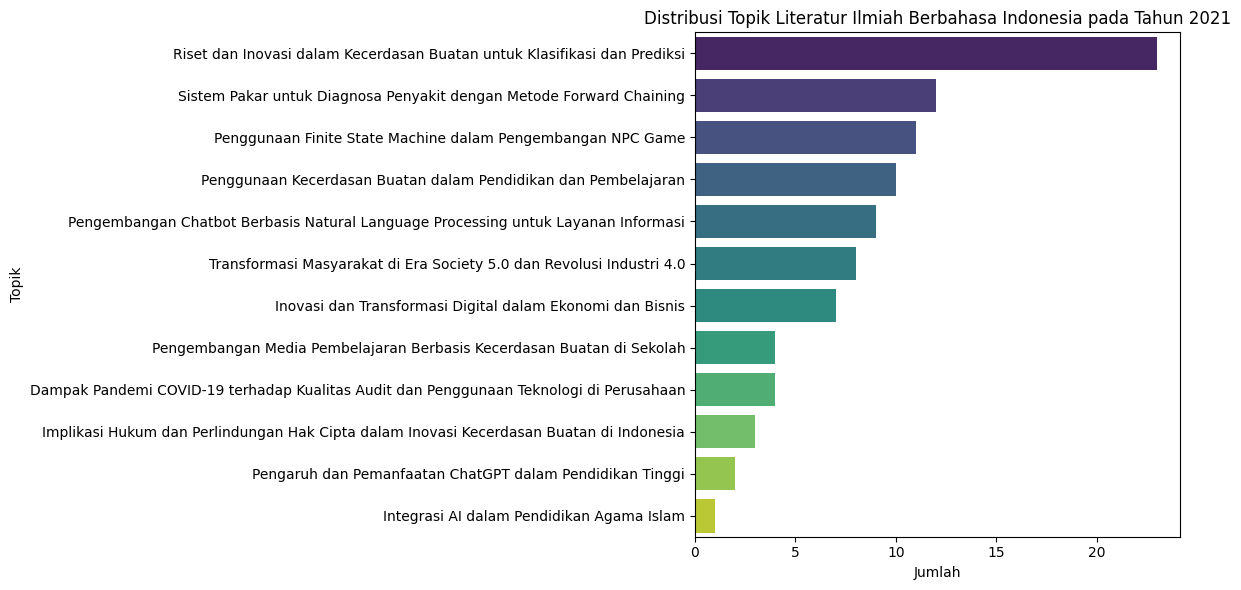

In [106]:
plot_topik_by_tahun(df,2021)

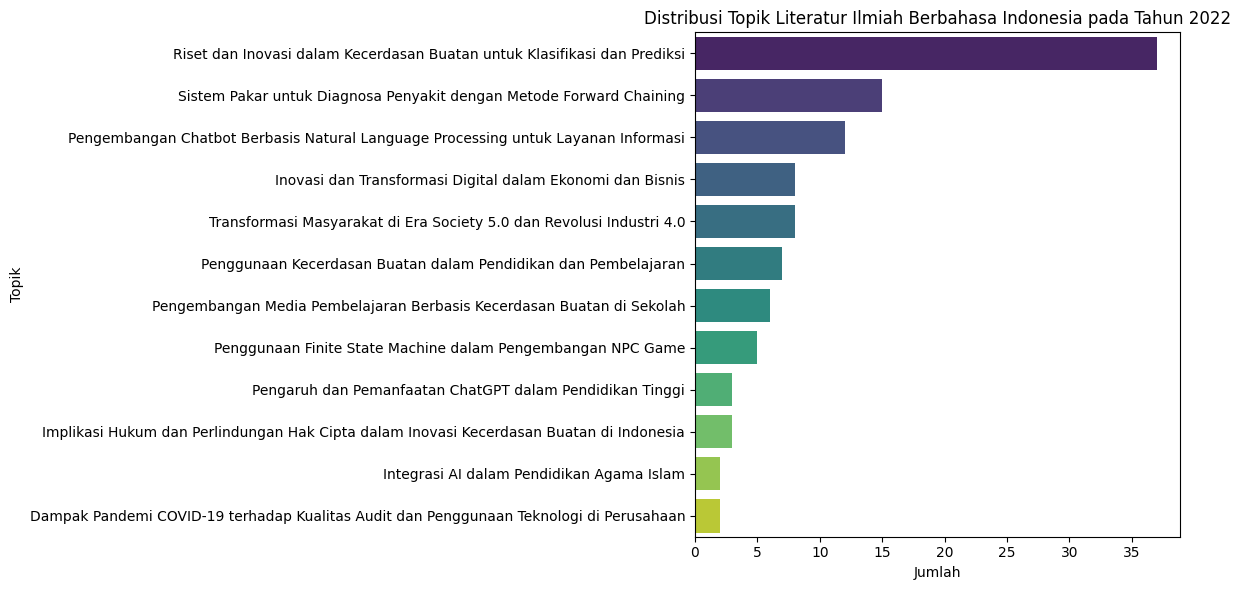

In [107]:
plot_topik_by_tahun(df,2022)

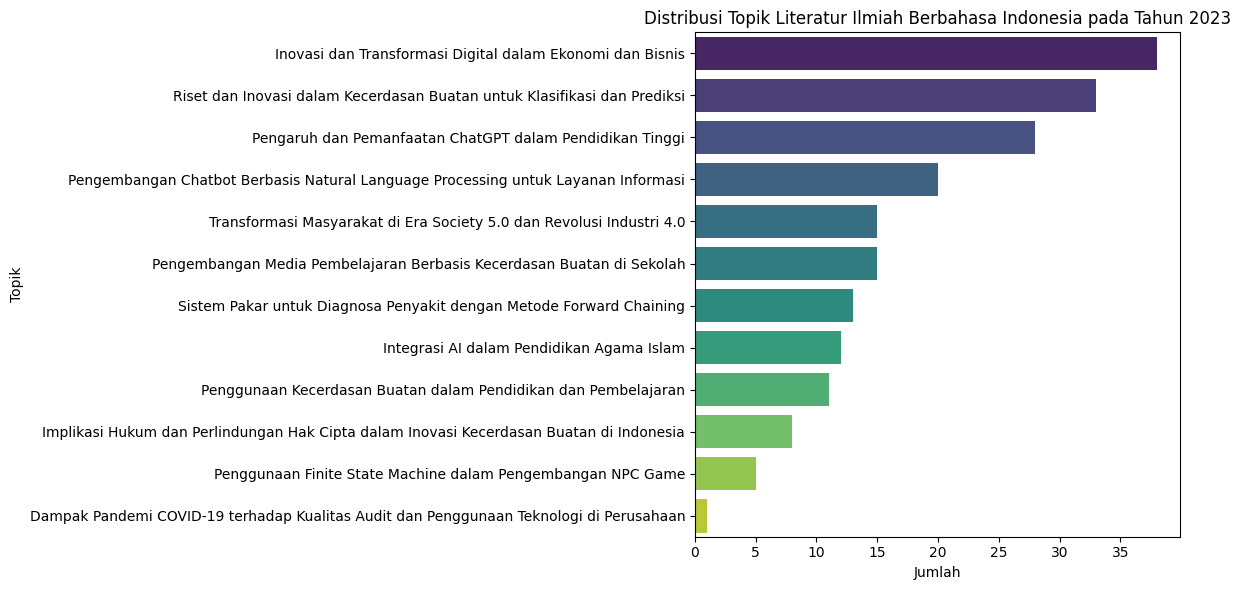

In [108]:
plot_topik_by_tahun(df,2023)

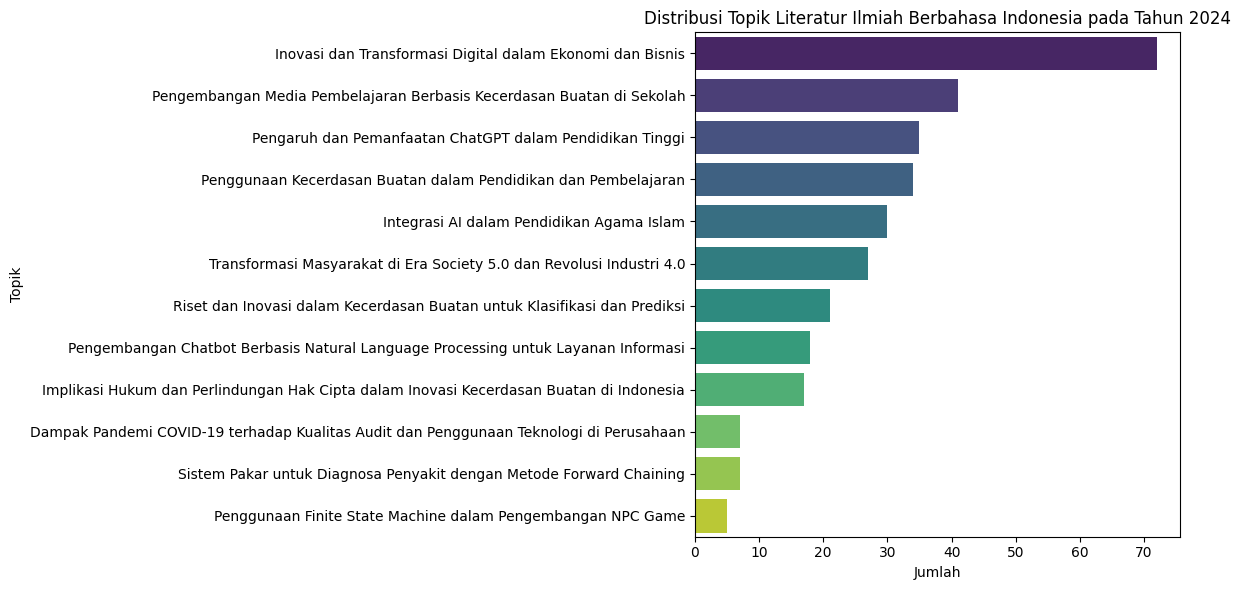

In [109]:
plot_topik_by_tahun(df,2024)

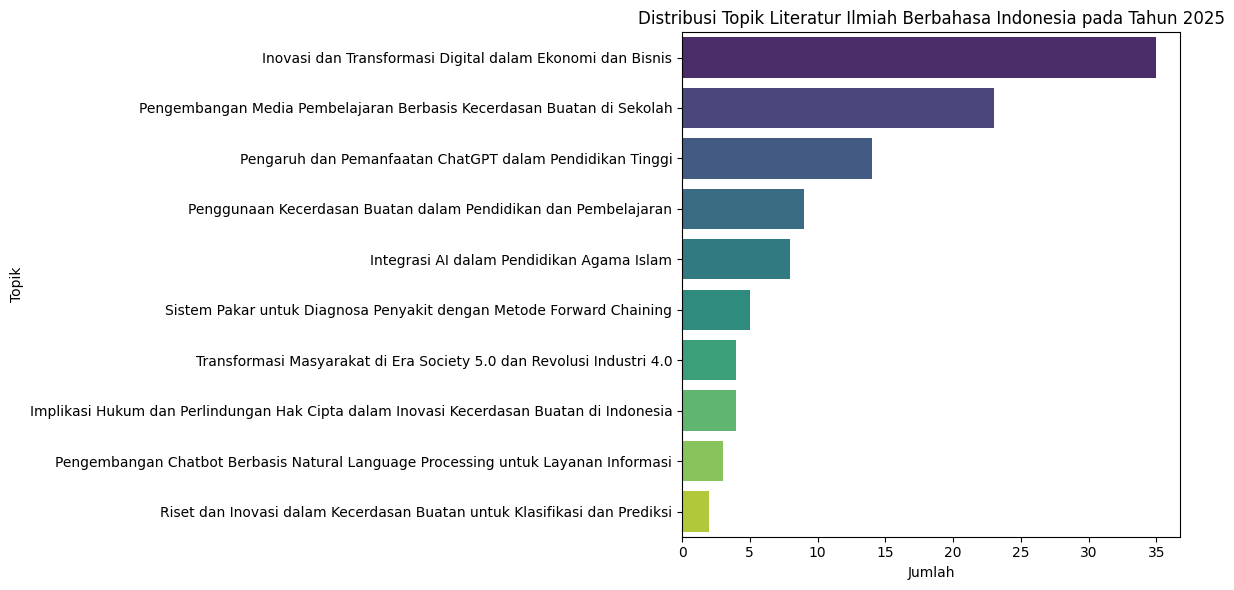

In [110]:
plot_topik_by_tahun(df,2025)

In [112]:
nmf_keywords = get_top_keyword(tfidf_vectorizer,nmf_model)

In [116]:
nmf_df = pd.DataFrame()
nmf_df['topic_id'] = np.arange(12)
nmf_df['keywords'] = nmf_keywords
nmf_df['topic_label'] = nmf_df['topic_id'].apply(lambda x : nmf_sum[str(x)]['label_topik'])
nmf_df['topic_desc'] = nmf_df['topic_id'].apply(lambda x : nmf_sum[str(x)]['deskripsi'])

In [117]:
nmf_df

,topic_id,keywords,topic_label,topic_desc
0,0,"[pendidikan, pembelajaran, islam, siswa, penel...",Integrasi AI dalam Pendidikan Agama Islam,Topik ini membahas dampak dan tantangan integr...
1,1,"[model, data, menggunakan, klasifikasi, akuras...",Riset dan Inovasi dalam Kecerdasan Buatan untu...,Topik ini mencakup penelitian dan inovasi dala...
2,2,"[digital, teknologi, data, bisnis, penelitian,...",Inovasi dan Transformasi Digital dalam Ekonomi...,Topik ini membahas peran dan dampak teknologi ...
3,3,"[game, state, algoritma, permainan, npc, finit...",Penggunaan Finite State Machine dalam Pengemba...,Topik ini membahas penerapan algoritma Finite ...
4,4,"[chatgpt, mahasiswa, penelitian, penggunaan, k...",Pengaruh dan Pemanfaatan ChatGPT dalam Pendidi...,Topik ini membahas bagaimana ChatGPT digunakan...
5,5,"[pakar, penyakit, sistem, chaining, forward, d...",Sistem Pakar untuk Diagnosa Penyakit dengan Me...,Topik ini mencakup literatur ilmiah tentang pe...
6,6,"[intelligence, artificial, learning, education...",Penggunaan Kecerdasan Buatan dalam Pendidikan ...,Topik ini membahas integrasi teknologi kecerda...
7,7,"[hukum, hak, cipta, perlindungan, indonesia, k...",Implikasi Hukum dan Perlindungan Hak Cipta dal...,Topik ini membahas urgensi pengaturan hukum te...
8,8,"[guru, pelatihan, siswa, pembelajaran, kegiata...",Pengembangan Media Pembelajaran Berbasis Kecer...,Topik ini membahas tentang pelatihan dan penge...
9,9,"[chatbot, informasi, aplikasi, layanan, sistem...",Pengembangan Chatbot Berbasis Natural Language...,Topik ini membahas implementasi dan pengembang...


In [118]:
nmf_df.to_csv('Topik Artikel Indonesia.csv',index=False)

In [120]:
df.to_csv('IND_articles_labeled.csv',index=False)

In [ ]:
# dump(nmf_model,'nmf_model.pkl')

In [ ]:
# nmf_sum = summarize(nmf_model,nmf_topics,tfidf_vectorizer)

In [ ]:
# with open("nmf_sum.json", "w", encoding="utf-8") as f:
#     json.dump(nmf_sum, f, ensure_ascii=False, indent=4)

In [ ]:
# with open("nmf_sum.json", "r", encoding="utf-8") as f:
#     data = json.load(f)

In [ ]:
df_tm['NMF_topic'] = np.argmax(nmf_topics,axis=1)
df_tm['NMF_topic'].value_counts()